# Feature Neutralization

One thing that makes predicting the stock market so hard is that the relationship between features and returns is "non-stationary". 

Features that have strong predictive power during some time periods may not have any in other time periods or may even completely reverse. This uncertainty is what we call "feature risk".

In order to create models that have consistent performance, it is often helpful to limit its exposure to feature risk with a method known as "feature neutralization".

In this notebook, we will 
1. Learn how to quantify feature risk
2. Measure our model's feature exposure
3. Apply feature neutralization to our predictions
4. Pickle and upload our feature-neutral model 

In [12]:
# Install dependencies
!pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle

# Inline plots
%matplotlib inline


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## 1. Feature Risk

In order to quantify feature risk, let us evaluate the performance of each feature on their own.

### Feature Sets & Groups
Instead of analyzing all 2000+ features all at once, let's pick a subset of features to analyze.

There are 3 feature sets of different sizes:
- `medium` contains "base" features which are each unique (P/E ratio vs analyst rating)
- `all` contains all "base" features in `medium` plus their variants (P/E by country vs P/E by sector)
- `small` contains the top features in `all` ranked by [feature importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) of our example model

There are 8 feature groups: `intelligence`, `wisdom`, `charisma`, `dexterity`, `strength`, `constitution`, `agility`, `serenity`. Each group contains a different kind of feature. For example all technical signals would be in one group, while all analyst predictions and ratings would be in another group.

In [13]:
import json
import pandas as pd
from numerapi import NumerAPI
napi = NumerAPI()

napi.download_dataset("v4.2/features.json");
feature_metadata = json.load(open("v4.2/features.json"))
feature_sets = feature_metadata["feature_sets"]

sizes = ["small", "medium", "all"]
groups = ["intelligence", "wisdom", "charisma", "dexterity", "strength", "constitution", "agility", "serenity", "all"]
subgroups = {}
for size in sizes:
    subgroups[size] = {}
    for group in groups:
        # intersection of feature sets
        subgroups[size][group] = set(feature_sets[size]).intersection(set(feature_sets[group]))

# as data frame
pd.DataFrame(subgroups).map(len).sort_values(by="all", ascending=False)

2023-08-30 17:39:08,870 INFO numerapi.utils: target file already exists
2023-08-30 17:39:08,873 INFO numerapi.utils: download complete


,small,medium,all
all,42,583,2132
constitution,2,134,335
charisma,3,116,290
agility,2,58,145
wisdom,3,56,140
strength,1,54,135
serenity,3,34,95
dexterity,4,21,51
intelligence,2,14,35


We will pick the intersection of `medium` and `serenity` to analyze.

In [14]:
feature_subset = list(subgroups["medium"]["serenity"])
len(feature_subset)

34

### Evaluating feature performance

What would the performance of each feature look like if we evaluated them as if they were model predictions? 

Since there is no model to train here, we can do this analysis on the training data.

In [15]:
# Download the training data and feature metadata
napi.download_dataset("v4.2/train_int8.parquet");

# Load the data
feature_cols = feature_metadata["feature_sets"]["medium"]
train = pd.read_parquet("v4.2/train_int8.parquet", columns=["era"] + feature_cols + ["target"])

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
# Comment out the line below to use all the data (higher memory usage, slower model training, potentially better performance)
train = train[train["era"].isin(train["era"].unique()[::4])]

2023-08-30 17:39:09,383 INFO numerapi.utils: target file already exists
2023-08-30 17:39:09,385 INFO numerapi.utils: download complete


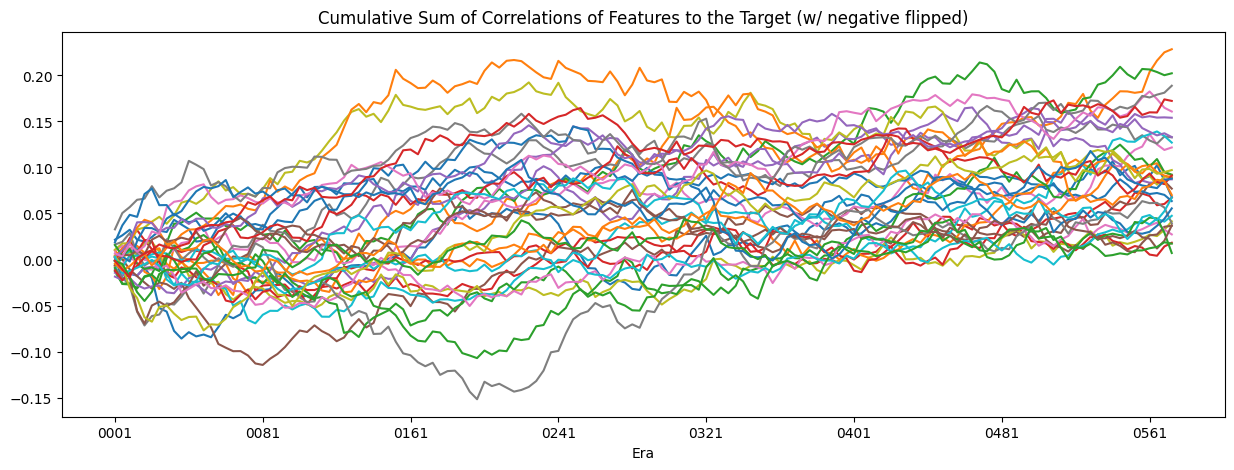

In [16]:
from scipy import stats
import numpy as np

def numerai_corr(preds, target):
    # special logic to handle features with 0 variance (NaNs filled with constant 2s)
    if preds.std() == 0:
        return np.nan
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    centered_target = target - target.mean()
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
    target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
    return np.corrcoef(preds_p15, target_p15)[0, 1]

# Compute the per-era correlation of each feature to the target
per_era_corrs = pd.DataFrame(index=train.era.unique())
for feature_name in feature_subset:
    per_era_corrs[feature_name] = train.groupby("era").apply(lambda d: numerai_corr(d[feature_name], d["target"]))

# Flip the sign of correlations for the features with negative average correlations (since the sign of each feature is arbitrary)
per_era_corrs *= np.sign(per_era_corrs.mean())

# Plot the per-era correlations
per_era_corrs.cumsum().plot(figsize=(15, 5), title="Cumulative Sum of Correlations of Features to the Target (w/ negative flipped)", legend=False, xlabel="Era");

Let's compute some summary performance metrics as we did in the previous notebook for our model predictions.

Apart from the standard performance metrics we have seen before, we introduce a new metric `delta`

`delta` is the absolute difference in `mean` correlation between the first and second half of the analysis period, and is a simple way for us to measure how much the performance of the feature changes over time. 

In [17]:
def metrics(per_era_corr):
    corr_mean = per_era_corr.mean()
    corr_std = per_era_corr.std(ddof=0)
    corr_sharpe = corr_mean / corr_std
    max_drawdown = -(per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

    eras = train.era.unique()
    corr_mean_first_half = per_era_corr.loc[eras[:len(eras)//2]].mean()
    corr_mean_second_half = per_era_corr.loc[eras[len(eras)//2:]].mean()
    delta = abs(corr_mean_first_half - corr_mean_second_half)

    return { "mean": corr_mean, "std": corr_std, "sharpe": corr_sharpe, "max_drawdown": max_drawdown, "delta": delta }

# compute performance metrics for each feature
feature_metrics = pd.DataFrame(index=feature_subset, columns=["mean", "std", "sharpe", "max_drawdown", "delta"])
for feature_name in feature_subset:
    feature_metrics.loc[feature_name] = metrics(per_era_corrs[feature_name])

# make all cells numeric 
feature_metrics = feature_metrics.apply(pd.to_numeric)

feature_metrics.sort_values("mean", ascending=False)

,mean,std,sharpe,max_drawdown,delta
feature_strigose_rugose_interjector,0.001587,0.009814,0.161706,-0.090501,3.219999e-04
feature_pennsylvanian_sibylic_chanoyu,0.001405,0.008630,0.162839,-0.056719,5.891572e-05
feature_honoured_observational_balaamite,0.001311,0.008323,0.157573,-0.070633,4.692690e-04
feature_ichthyotic_roofed_yeshiva,0.001197,0.006447,0.185643,-0.053682,8.730129e-04
feature_exploitative_jetty_oujda,0.001117,0.007429,0.150339,-0.048455,3.838098e-04
feature_styloid_subdermal_cytotoxin,0.001070,0.006940,0.154150,-0.058597,6.228628e-04
feature_plum_anemometrical_guessing,0.000924,0.006496,0.142234,-0.041113,1.081759e-03
feature_aguish_commissioned_tessitura,0.000922,0.008206,0.112337,-0.063597,1.338218e-03
feature_gubernacular_liguloid_frankie,0.000882,0.007530,0.117191,-0.082251,6.352135e-04
feature_demolished_unfrightened_superpower,0.000846,0.007418,0.113985,-0.053589,3.118252e-04


Looking at these summary visualizations below, the most obvious observation is that `mean` and `sharpe` seem strongly correlated. This should not be suprising given that `sharpe` is just `mean` divided by `std`.

A more interesting obvservation is that `mean` does not seem to be strongly correlated with `std`, `max_drawdown`, or `delta`. This tells us very clearly that just because a feature has high `mean` does not mean that it is consistent or low risk.

To better understand feature risk, let us examine `std`, `max_drawdown`, and `delta` more closely.


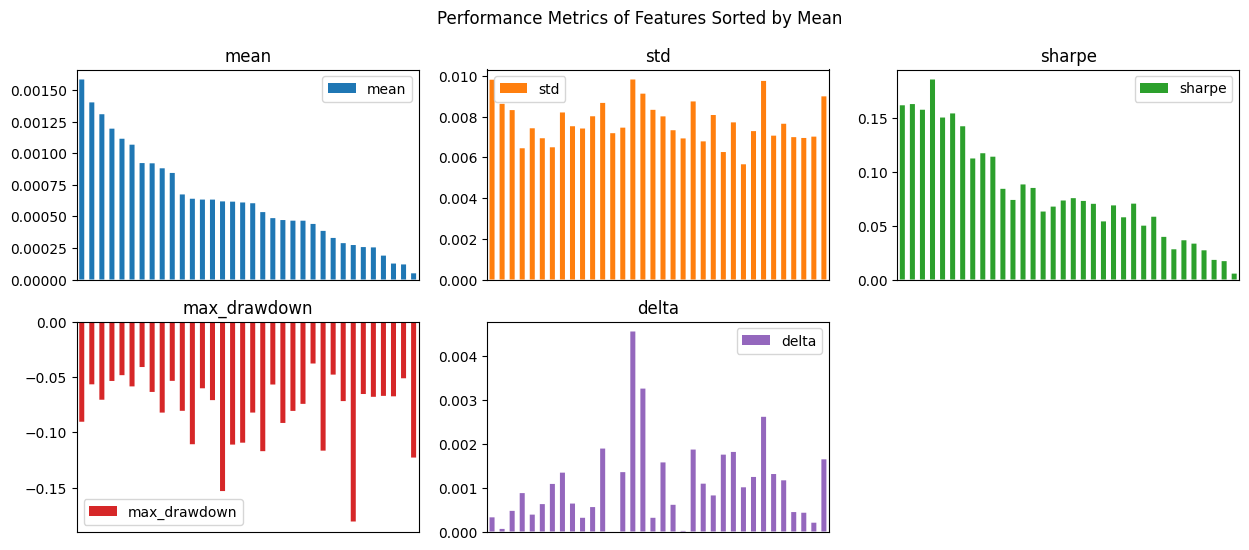

In [18]:
# plot the performance metrics of the features as bar charts sorted by mean
feature_metrics.sort_values("mean", ascending=False).plot.bar(
    subplots=True, figsize=(15, 6), layout=(2, 3), sharex=False, xticks=[], snap=False,
    title="Performance Metrics of Features Sorted by Mean"
);

### Comparing feature risk

Below is a comparison of the highest and lowest `std` features. Which one looks more risky to you and why?

One might argue that the orange line looks more risky given its more sudden and violent reversals. Extrapolating forward, we may expect this volatility to continue out of sample.

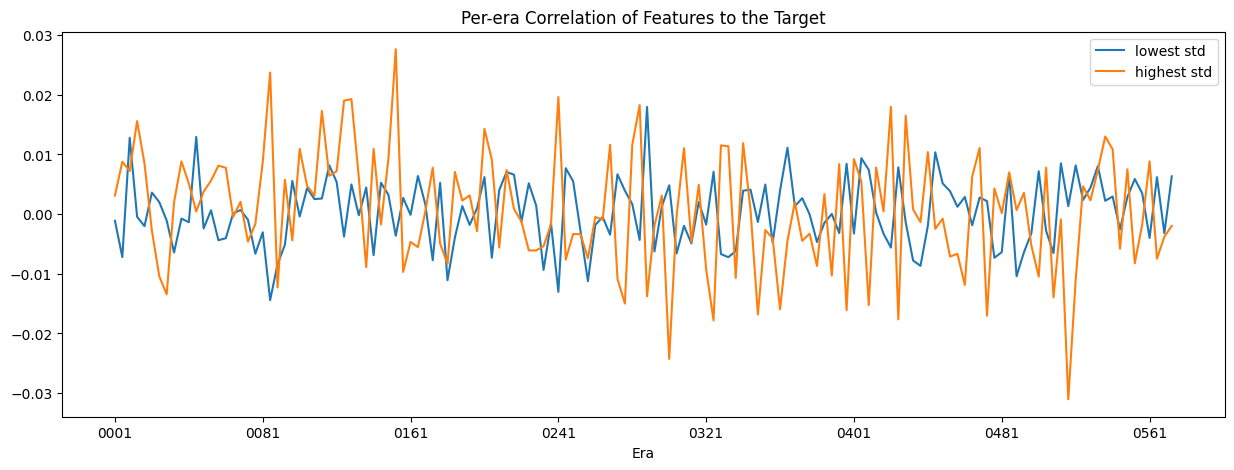

In [19]:
import matplotlib.pyplot as plt

# plot the per era correlation of the feature with the highest vs lowest std
per_era_corrs[[feature_metrics["std"].idxmin(), feature_metrics["std"].idxmax()]].plot(
    figsize=(15, 5), title="Per-era Correlation of Features to the Target", xlabel="Era"
) 
plt.legend(["lowest std", "highest std"]);

Below is a comparison of the highest and lowest `delta` features. Which one looks more risky to you and why?

One might argue that the orange line looks more risky given the complete reversal in performance between the first and second half, despite both ending up in a similar spot. Extraoploating forward, we may expect this feature to stop working completely out-of-sample. 

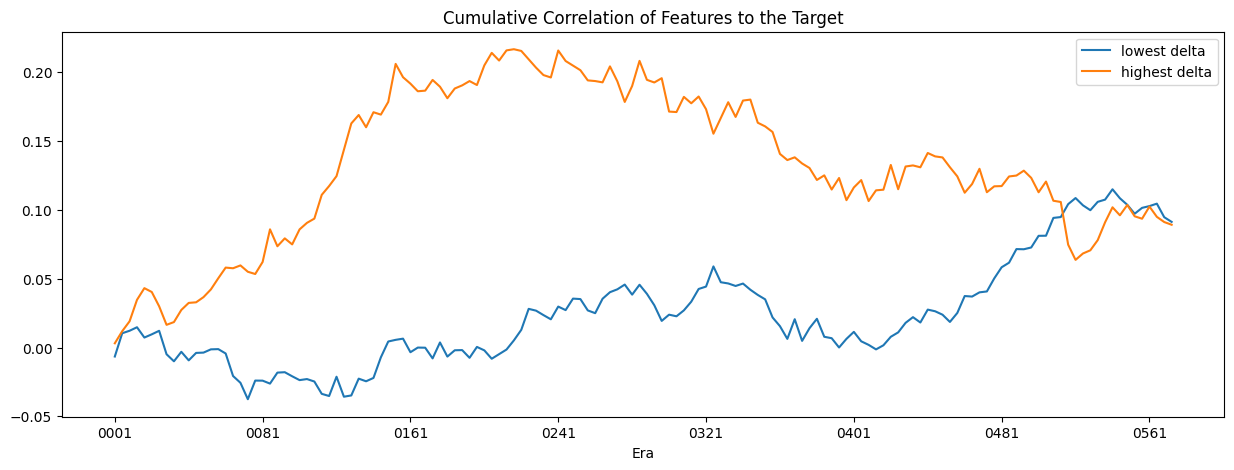

In [20]:
# plot the cumulative per era correlation of the feature with the highest vs lowest delta
per_era_corrs[[feature_metrics["delta"].idxmin(), feature_metrics["delta"].idxmax()]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Era"
) 
plt.legend(["lowest delta", "highest delta"]);

Below is a comparison of the highest and lowest `max_drawdown` features. Which one looks more risky to you and why?

One might argue that the orange line is more risky given the huge drawdown in the middle, despite both ending up in a similar spot. Extrapolating forward, we may expect it to have another big drawdown out of sample.

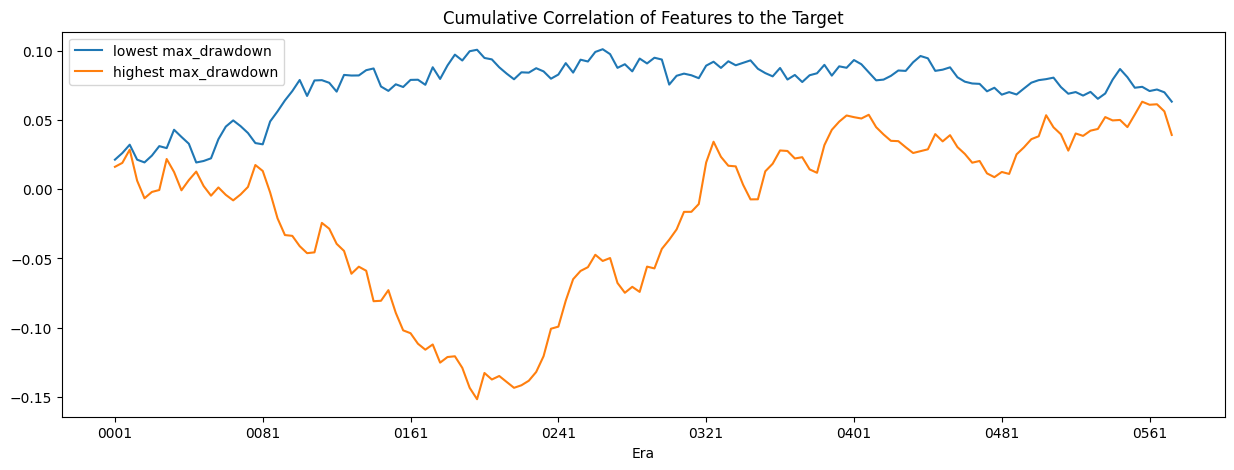

In [21]:
# plot the cumulative per era correlation of the feature with the highest vs lowest max_drawdown
per_era_corrs[[feature_metrics["max_drawdown"].idxmax(), feature_metrics["max_drawdown"].idxmin()]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Era"
)
plt.legend(["lowest max_drawdown", "highest max_drawdown"]);

The metrics analyzed above are only a few of many different ways you can quantify feature risk. What are some other ways you can think of? 

## 2. Feature Exposure 

`Feature exposure` is a measure of a model's exposure to the risk of individual features, given by the Pearson correlation between a model's predictions and each feature. 

Let's train a model and measure the feature exposure of its predictions.

In [22]:
import lightgbm as lgb

model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=2**5-1,
    colsample_bytree=0.1
)
model.fit(
    train[feature_cols],
    train["target"]
);

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2915
[LightGBM] [Info] Number of data points in the train set: 606176, number of used features: 583
[LightGBM] [Info] Start training from score 0.499979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [23]:
# Download validation data 
napi.download_dataset("v4.2/validation_int8.parquet");

# Load the validation data, filtering for data_type == "validation"
validation = pd.read_parquet("v4.2/validation_int8.parquet", columns=["era", "data_type"] + feature_cols + ["target"]) 
validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]

# Downsample every 4th era to reduce memory usage and speedup validation (suggested for Colab free tier)
# Comment out the line below to use all the data
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

# Embargo overlapping eras from training data
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

# Generate predictions against the out of sample validation features
validation["prediction"] = model.predict(validation[feature_cols])

2023-08-30 17:40:18,379 INFO numerapi.utils: target file already exists
2023-08-30 17:40:18,381 INFO numerapi.utils: download complete


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


### Visualizing feature exposures

As seen in the chart below, our model seems to be consistently correlated to at least some features. If these features suddenly reverse or stop working, then our model predictions will likely exhibit the same risky characteristics we saw above. 


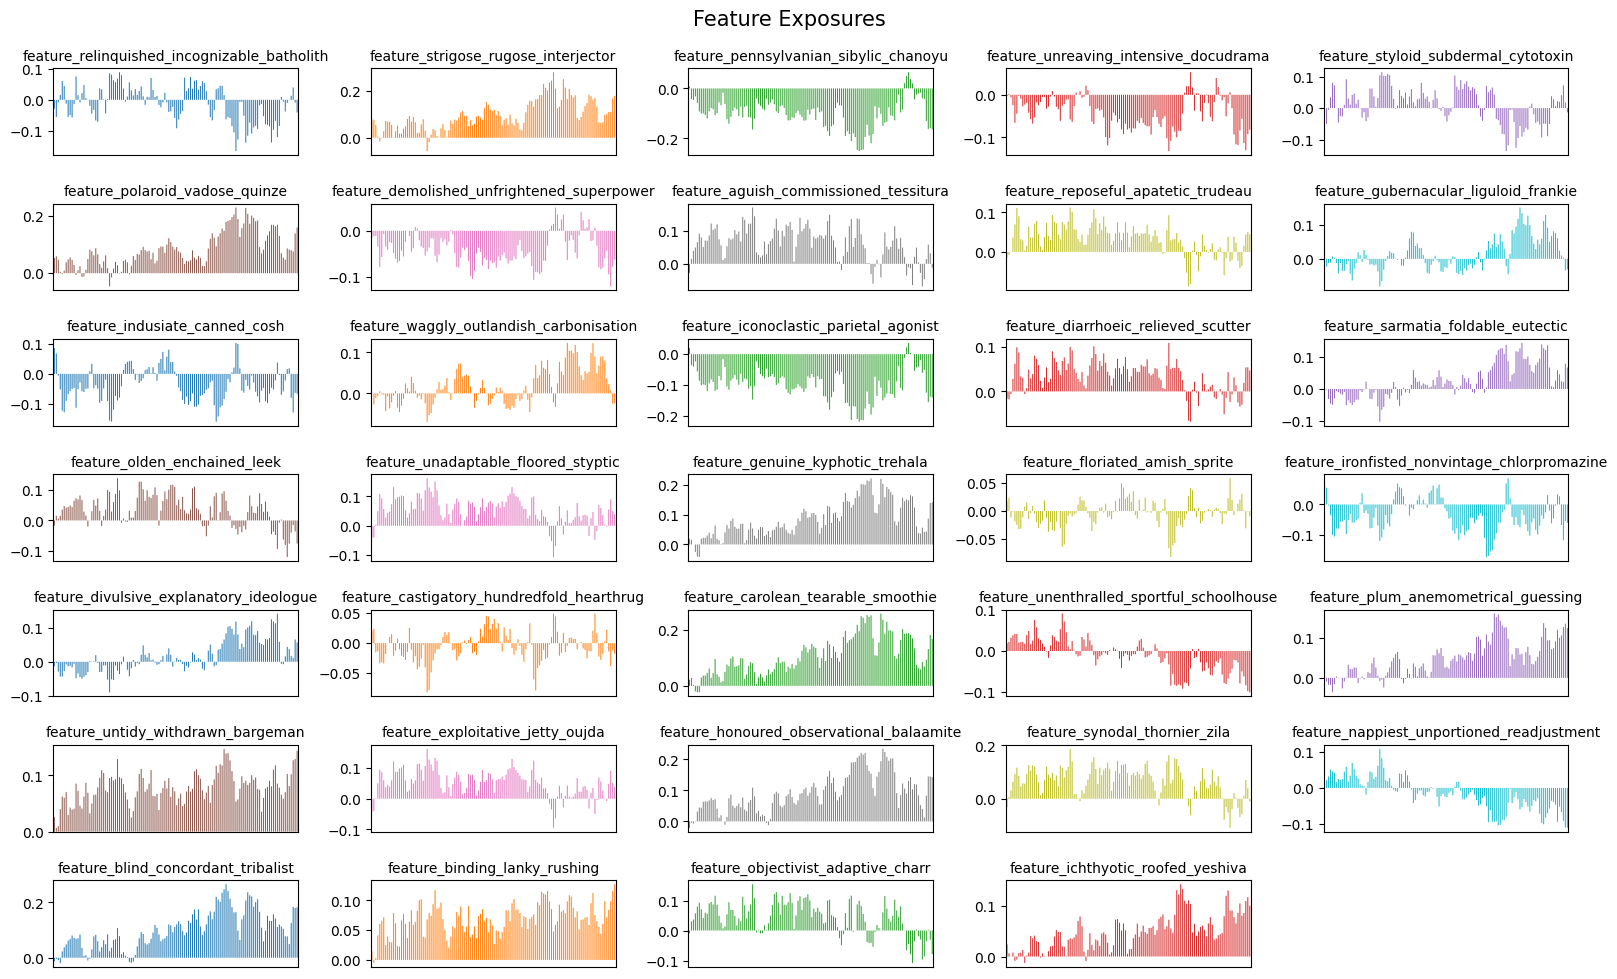

In [24]:
# Compute the Peason correlation of the predictions with each feature
feature_exposures = validation.groupby("era").apply(lambda d: d[feature_subset].corrwith(d["prediction"]))

# Plot the feature exposures as bar charts 
feature_exposures.plot.bar(
    subplots=True, figsize=(16, 10), layout=(7,5), sharex=False, title="Feature Exposures", xticks=[], legend=False, snap=False
);
for ax in plt.gcf().axes:
    ax.set_xlabel("")
    ax.title.set_fontsize(10)
plt.tight_layout(pad=1.5)
plt.gcf().suptitle("Feature Exposures", fontsize=15);

### Max feature exposure 

Another perhaps more useful way to visualize the overall feature exposure of our model is to look at the per-era max feature exposure across all features. This is a simple way for us to estimate the maximum feature risk we are exposed to across all features at any given time.

Note that we are only measuring the feature exposures of the subset of features we chose to analyze.

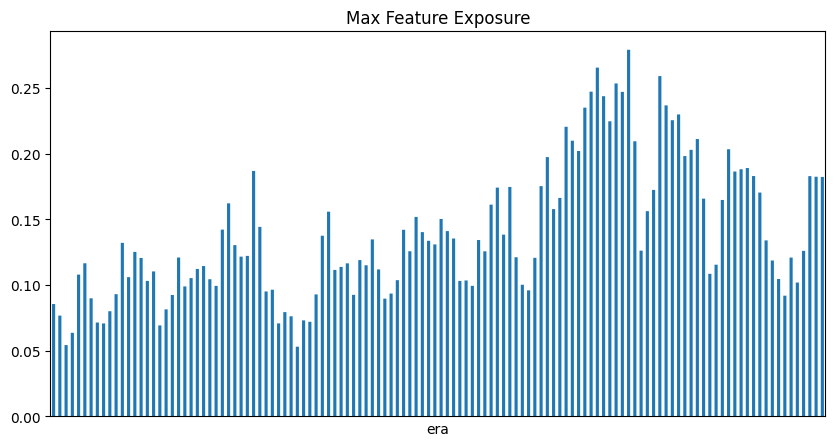

In [25]:
# Plot the max feature exposure per era
max_feature_exposure = feature_exposures.max(axis=1)
max_feature_exposure.plot(title="Max Feature Exposure", kind="bar", figsize=(10, 5), xticks=[], snap=False);

In [26]:
# Mean max feature exposure across eras
max_feature_exposure.mean()

0.1395077065249037

## 3. Feature Neutralization

`Feature Neutralization` is a way to reduce feature exposure. 

At a high level, you can think of it as removing the component of your predictions that are linearly correlated with certain features, leaving only the residual non-linear component.

Read these forum posts if you want to learn more about the math behind the feature neutralization: 
- https://forum.numer.ai/t/model-diagnostics-feature-exposure/899
- https://forum.numer.ai/t/an-introduction-to-feature-neutralization-exposure/4955

In [27]:
# Neutralize predictions to features
def neutralize(predictions: pd.DataFrame, features: pd.DataFrame, proportion: float = 1.0) -> pd.DataFrame:
    # add a constant term the features so we can fit the bias/offset term
    features = np.hstack((features, np.array([np.mean(predictions)] * len(features)).reshape(-1, 1)))
    # remove the component of the predictions that are linearly correlated with features
    return predictions - proportion * features @ (np.linalg.pinv(features, rcond=1e-6) @ predictions)

### Applying feature neutralization

Let's apply feature neutralization to our predictions at different porportions and see how that impacts max feature exposure.

In [28]:
# Neutralize predictions per-era againat features at different proportions
proportions = [0.25, 0.5, 0.75, 1.0]
for proportion in proportions:
    neutralized = validation.groupby("era").apply(lambda d: neutralize(d["prediction"], d[feature_subset], proportion=proportion))
    validation[f"neutralized_{proportion*100:.0f}"] = neutralized.reset_index().set_index("id")["prediction"] 

# Align the neutralized predictions with the validation data
prediction_cols = ["prediction"] + [f for f in validation.columns if "neutralized" in f]
validation[["era"] + prediction_cols + ["target"]]

,era,prediction,neutralized_25,neutralized_50,neutralized_75,neutralized_100,target
id,,,,,,,
n002a15bc5575bbb,0579,0.507566,0.382174,0.256782,0.131390,0.005998,0.25
n00309caaa0f955e,0579,0.509038,0.383462,0.257885,0.132308,0.006731,0.50
n00576b397182463,0579,0.495131,0.369835,0.244538,0.119241,-0.006055,0.50
n00633405d59c6a1,0579,0.500930,0.375568,0.250207,0.124846,-0.000516,1.00
n008c2eefc8911c7,0579,0.496661,0.370769,0.244877,0.118985,-0.006907,0.50
...,...,...,...,...,...,...,...
nffd5af15959f152,1071,0.489949,0.365007,0.240065,0.115123,-0.009819,0.50
nffd9899640fa670,1071,0.503236,0.375995,0.248755,0.121514,-0.005726,0.25
nffdc9ed5105d9c3,1071,0.508867,0.383868,0.258868,0.133869,0.008869,0.50


In the chart below, we can see that we are able to progressively reduce our max feature exposure all the way down to 0 with a nuetralization porportion = 100%. This tells us that our neutralization function is working as expected!

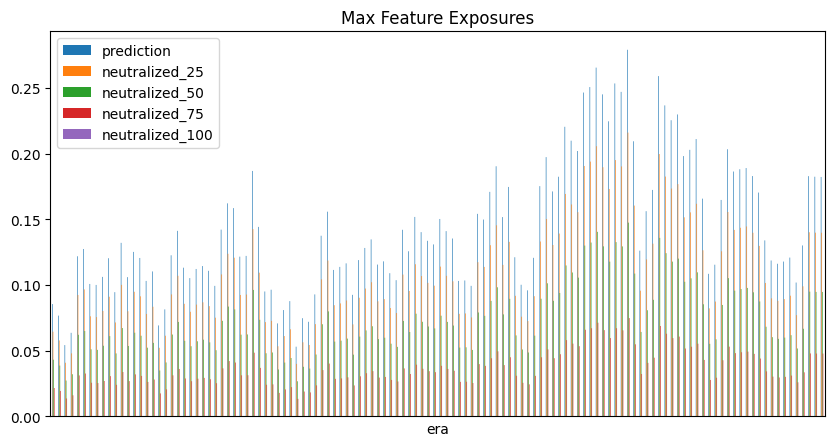

In [29]:
# Compute max feature exposure for each set of predictions
max_feature_exposures = {}
for col in prediction_cols:
    max_feature_exposures[col] = validation.groupby("era").apply(lambda d: d[feature_subset].corrwith(d[col]).abs().max())
max_feature_exposures = pd.DataFrame(max_feature_exposures)

# Plot max feature exposures 
max_feature_exposures.plot.bar(figsize=(10, 5), title="Max Feature Exposures", xticks=[], snap=False);

### Performance impact of neutralization 

Looking at the performance chart below, we see that our performance improves (slightly) as we increase the porportion of neutralization applied, but the overall shape of the line remains largely the same.

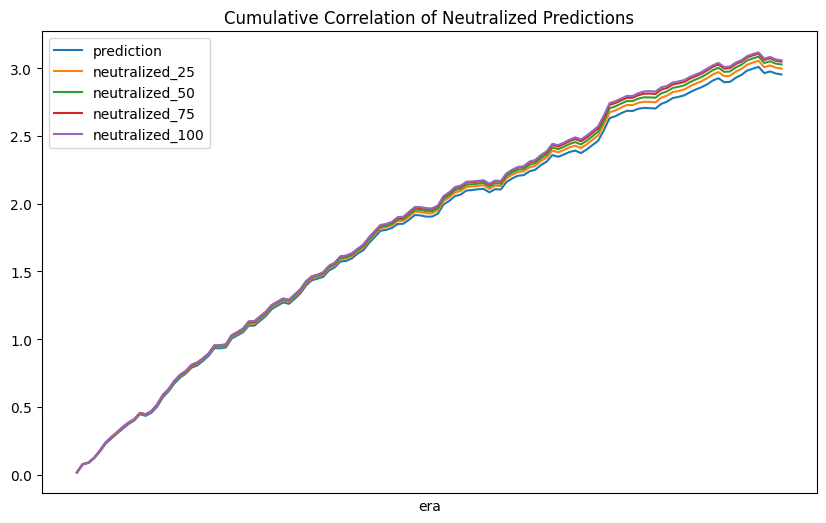

In [30]:
# Plot cumulative correlations
correlations = {}
cumulative_correlations = {}
for col in prediction_cols:
    correlations[col] = validation.groupby("era").apply(lambda d: numerai_corr(d[col], d["target"]))
    cumulative_correlations[col] = correlations[col].cumsum() 
pd.DataFrame(cumulative_correlations).plot(title="Cumulative Correlation of Neutralized Predictions", figsize=(10, 6), xticks=[]);

Looking at the performance metrics below, we see that both `mean` and `sharpe` increase (slightly) as we increase the porportion of feature neutralization applied, with `std` and `max_drawdown` at similar levels.

In [31]:
summary_metrics = {}
for col in prediction_cols:
    mean = correlations[col].mean()
    std = correlations[col].std()
    sharpe = mean / std
    rolling_max = cumulative_correlations[col].expanding(min_periods=1).max()
    max_drawdown = (rolling_max - cumulative_correlations[col]).max()
    summary_metrics[col] = {
        "mean": mean,
        "std": std,
        "sharpe": sharpe,
        "max_drawdown": max_drawdown,
    }
pd.set_option('display.float_format', lambda x: '%f' % x)
pd.DataFrame(summary_metrics).T

,mean,std,sharpe,max_drawdown
prediction,0.023814,0.022222,1.071638,0.056556
neutralized_25,0.024162,0.022463,1.075632,0.057730
neutralized_50,0.024408,0.022619,1.079131,0.058023
neutralized_75,0.024582,0.022688,1.083499,0.058411
neutralized_100,0.024660,0.022669,1.087825,0.057935


### Neutralizing different groups
Given that we trained our model on the entire `medium` set of features, it is not surprising that neutralizing just a small subset of 34 features will have a small impact on performance.  

Let's re-run this experiment but this time try to neutralize the each group within `medium` while holding porportion constant at 100%.

As we can see in the performance chart below, neutralizing against the different groups gives a much more pronounced impact on performance, which makes sense since these groups are fundamentally different from one another. 

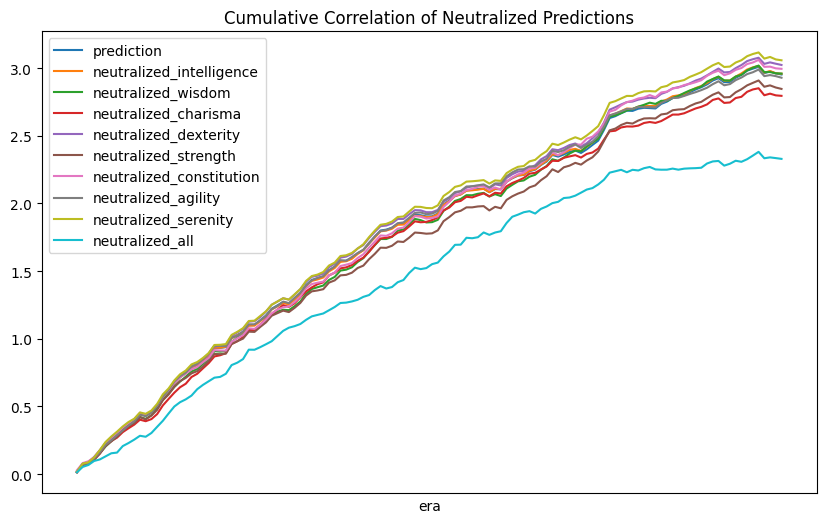

In [32]:
for group in groups:
    feature_subset = list(subgroups["medium"][group])
    neutralized = validation.groupby("era").apply(lambda d: neutralize(d["prediction"], d[feature_subset]))
    validation[f"neutralized_{group}"] = neutralized.reset_index().set_index("id")["prediction"] 

prediction_cols2 = ["prediction"] + [f"neutralized_{group}" for group in groups]
correlations2 = {}
cumulative_correlations2 = {}
for col in prediction_cols2:
    correlations2[col] = validation.groupby("era").apply(lambda d: numerai_corr(d[col], d["target"]))
    cumulative_correlations2[col] = correlations2[col].cumsum() 
pd.DataFrame(cumulative_correlations2).plot(title="Cumulative Correlation of Neutralized Predictions", figsize=(10, 6), xticks=[]);


Looking at the performance metrics below, we see that neutralizing against some groups help while others seem to hurt. Can you think of why this might be the case?

Perhaps the most interesting observation is that neutralizing against `all` of the groups within `medium` performs by far the worst in terms of `mean` and `sharpe`, but also are the most "consistent" in the sense of having the lowest `std` and `max_drawdown`. Can you think of why this might be the case?

In [33]:
summary_metrics2 = {}
for col in prediction_cols2:
    mean = correlations2[col].mean()
    std = correlations2[col].std()
    sharpe = mean / std
    rolling_max = cumulative_correlations2[col].expanding(min_periods=1).max()
    max_drawdown = (rolling_max - cumulative_correlations2[col]).max()
    summary_metrics2[col] = {
        "mean": mean,
        "std": std,
        "sharpe": sharpe,
        "max_drawdown": max_drawdown,
    }
pd.set_option('display.float_format', lambda x: '%f' % x)
pd.DataFrame(summary_metrics2).T

,mean,std,sharpe,max_drawdown
prediction,0.023814,0.022222,1.071638,0.056556
neutralized_intelligence,0.023861,0.022098,1.079767,0.057864
neutralized_wisdom,0.023869,0.021835,1.093163,0.058691
neutralized_charisma,0.022541,0.020453,1.102100,0.056146
neutralized_dexterity,0.024381,0.022108,1.102857,0.053388
neutralized_strength,0.022954,0.022490,1.020655,0.062432
neutralized_constitution,0.024152,0.022287,1.083700,0.065878
neutralized_agility,0.023621,0.022657,1.042540,0.060657
neutralized_serenity,0.024660,0.022669,1.087825,0.057935
neutralized_all,0.018785,0.019620,0.957464,0.051902


Based on our simple analysis above, it seems like neutralizing `serenity` group within `medium` at porportion of 1 may be the best choice for performance. What do you think? 

In your research, you may want to experiment with neutralizing different subsets of features at different porportions and make your own judgement on how to balance the risk reward benefits of neutralization. You may even consider incorporating neutralization into the objective function of your training instead of applying it to predictions like we do here. 

Lastly, whether you want to apply feature neutralization to your model or not is completely up to you. In fact, many great performing models have no feature neutralization at all!   



## 4. Building a feature-neutral model 

To wrap up this notebook, let's build and upload our new feature neutral model.

In [34]:
def predict_neutral(live_features: pd.DataFrame) -> pd.DataFrame:
    # make predictions using all features
    predictions = pd.Series(model.predict(live_features[feature_cols]), index=live_features.index) 
    # neutralize predictions to a subset of features
    neutralized = neutralize(predictions, live_features[feature_subset], 1.0)
    submission = pd.Series(neutralized).rank(pct=True, method="first")
    return submission.to_frame("prediction")

In [35]:
# Quick test
napi.download_dataset("v4.2/live_int8.parquet")
live_features = pd.read_parquet(f"v4.2/live_int8.parquet", columns=feature_cols)
predict_neutral(live_features)

2023-08-30 17:42:09,715 INFO numerapi.utils: target file already exists
2023-08-30 17:42:09,716 INFO numerapi.utils: download complete


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,prediction
id,
n00011beb76fb85a,0.716966
n00030395c4ae306,0.823409
n00062925bf2d5a2,0.901713
n000af1f9814addb,0.426794
n001429f265846a1,0.741232
...,...
nffd6ffb0975a454,0.323409
nffe1891a18ae870,0.155995
nffe21a8f38193a1,0.089519


In [36]:
# Use the cloudpickle library to serialize your function and its dependencies
import cloudpickle
p = cloudpickle.dumps(predict_neutral)
with open("predict_neutral.pkl", "wb") as f:
    f.write(p)

In [37]:
# Download file if running in Google Colab
try:
    from google.colab import files
    files.download('predict_neutral.pkl')
except:
    pass

That's it! Now head back to [numer.ai](numer.ai) to upload your model!